[info] Using font: NanumGothic


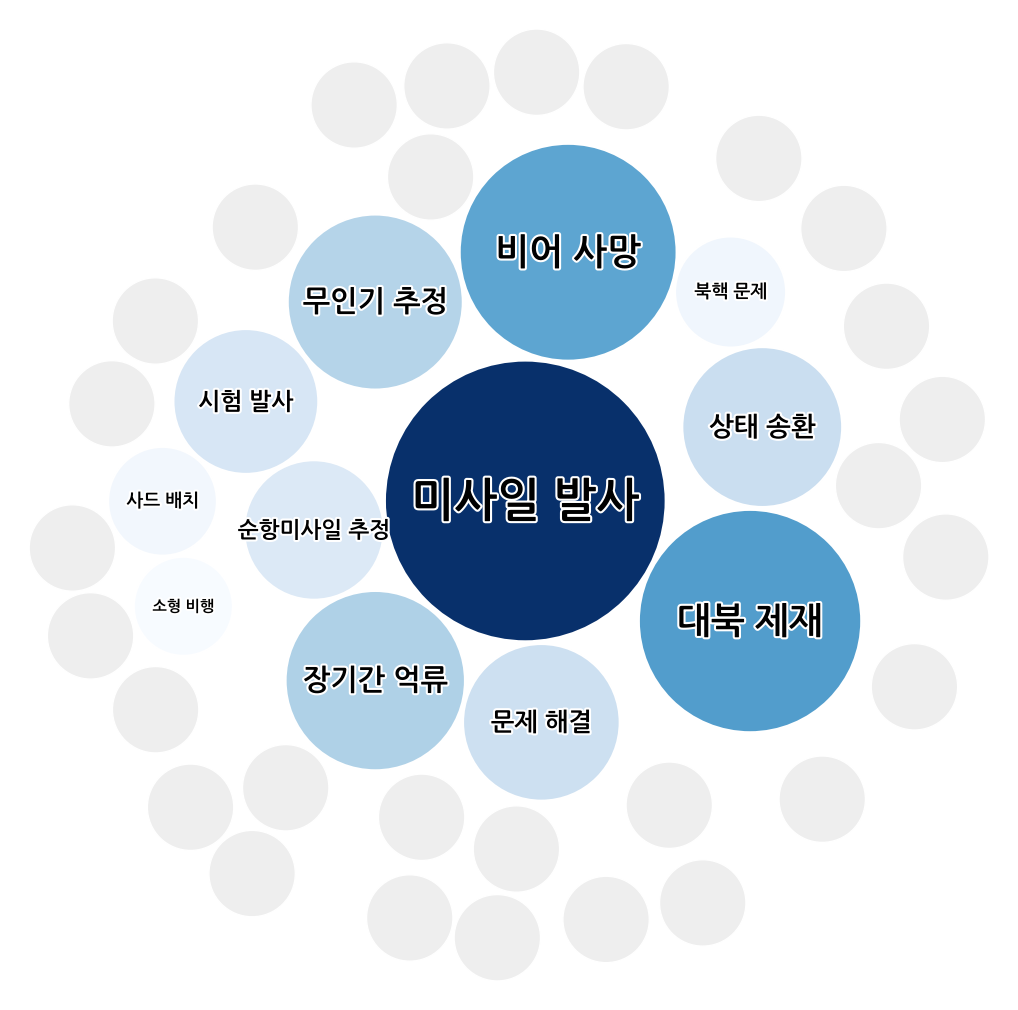

In [ ]:
# -*- coding: utf-8 -*-
import os, json, math, random, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
from matplotlib import font_manager

# ===== 사용자 입력 =====
YEAR = 2017          # 예: 2016
MONTH = 6            # 1~12 (1만 넣어도 "01월"로 포맷)
BASE_DIR = "/home/ds4_sia_nolb/#FINAL_POLARIS/05_Event_top10/re_monthly_results_cluster"

# "01월" 형태로 변환
MONTH_STR = f"{MONTH:02d}"

# 최종 JSON 경로
JSON_PATH = f"{BASE_DIR}/{YEAR}_{MONTH_STR}_keyword_grouped.json"

# ===== 폰트 직접 등록 & 강제 선택 =====
# 시스템에 설치될 가능성이 높은 경로 후보를 뒤져서 .ttf/.otf/.ttc 파일을 직접 등록
FONT_PATH_GLOBS = [
    "/usr/share/fonts/truetype/nanum/*.ttf",
    "/usr/share/fonts/opentype/noto/*CJK*.*",
    "/usr/share/fonts/opentype/noto/*SansKR*.*",
    "/usr/share/fonts/*/*Noto*KR*.*",
    "/usr/share/fonts/*/*Nanum*.*",
    "~/.local/share/fonts/*Nanum*.*",
    "~/.local/share/fonts/*Noto*KR*.*",
]

font_files = []
for pattern in FONT_PATH_GLOBS:
    font_files.extend(glob.glob(os.path.expanduser(pattern)))

# Matplotlib에 폰트 파일을 직접 등록
for fp in font_files:
    try:
        font_manager.fontManager.addfont(fp)
    except Exception:
        # 깨진/이상한 파일은 건너뜀
        pass

# 등록 후 사용 가능한 폰트 목록 갱신
available_fonts = {f.name for f in font_manager.fontManager.ttflist}

# 선호 순서(발견되는 첫 폰트를 사용)
FONT_CANDIDATES = ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "NanumBarunGothic", "AppleGothic"]
picked_font = next((n for n in FONT_CANDIDATES if n in available_fonts), None)

if picked_font is None:
    # 여전히 못 찾으면 후보군 이름을 한꺼번에 sans-serif에 주입(일부 환경에서 family matching로 매칭될 수 있음)
    mpl.rcParams["font.sans-serif"] = ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "DejaVu Sans"]
    print("[경고] 한글 폰트 family 이름을 직접 찾지 못했습니다. 그래도 계속 DejaVu Sans가 뜨면 아래 쉘 명령으로 경로를 확인하세요.")
else:
    mpl.rcParams["font.family"] = picked_font
    print(f"[info] Using font: {picked_font}")

# 마이너스 기호 깨짐 방지
mpl.rcParams["axes.unicode_minus"] = False

# ===== 1) 데이터 =====
if not os.path.exists(JSON_PATH):
    raise FileNotFoundError(f"JSON 파일을 찾을 수 없습니다: {JSON_PATH}")

with open(JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

items = [{"phrase": k["phrase"], "score": float(k["score"])}
         for k in data.get("keywords", []) if float(k.get("score", 0)) > 0]
if not items:
    raise ValueError("키워드 데이터가 비어 있습니다.")

# ===== 2) 반지름(면적 ~ score) =====
smax = max(it["score"] for it in items)
SCALE = 2.6
for it in items:
    it["r"] = SCALE * math.sqrt(it["score"] / smax)

# ===== 3) 초기 배치(비겹침) =====
items.sort(key=lambda x: x["r"], reverse=True)
MARGIN = 0.06  # 최소 간격 여유

def overlaps_any(x, y, r, circles, margin=MARGIN):
    for (cx, cy, cr, _) in circles:
        if (x - cx)**2 + (y - cy)**2 < (r + cr + margin)**2:
            return True
    return False

def place_circle(r, circles, margin=MARGIN):
    if not circles:
        return 0.0, 0.0
    angle = random.random() * 2*math.pi
    rad, step_r, step_a = 0.0, max(0.05, r*0.22), 0.18
    x = y = 0.0
    for _ in range(22000):
        x = rad*math.cos(angle)
        y = rad*math.sin(angle)
        if not overlaps_any(x, y, r, circles, margin):
            return x, y
        angle += step_a
        rad   += step_r
    return x, y  # 드문 안전탈출

main = []
for it in items:
    x, y = place_circle(it["r"], main, MARGIN)
    main.append((x, y, it["r"], it["phrase"]))

# ===== 4) 하드 비겹침 보정 유틸 =====
def resolve_overlaps(circles, margin=MARGIN, iters=200, alpha=0.55):
    pts = np.array([[x, y] for (x, y, r, lab) in circles], float)
    rs  = np.array([r for (x, y, r, lab) in circles], float)
    n = len(circles)
    for _ in range(iters):
        moved = 0
        for i in range(n):
            xi, yi = pts[i]; ri = rs[i]
            for j in range(i+1, n):
                xj, yj = pts[j]; rj = rs[j]
                dx, dy = xj - xi, yj - yi
                min_d = ri + rj + margin
                dist2 = dx*dx + dy*dy
                if dist2 < min_d*min_d:
                    dist = math.sqrt(dist2) if dist2 > 0 else 1e-6
                    ux, uy = dx/dist, dy/dist
                    push = (min_d - dist) * 0.5 * alpha
                    pts[i, 0] -= ux * push; pts[i, 1] -= uy * push
                    pts[j, 0] += ux * push; pts[j, 1] += uy * push
                    moved += 1
        if moved == 0:
            break
    return [(float(x), float(y), r, lab) for (x, y), (_, _, r, lab) in zip(pts, circles)]

# ===== 5) 중앙 집중(인력 디케이) + 비겹침 수렴 =====
def compact_center_decay(circles, margin=MARGIN,
                         steps=10, inner_iters=40,
                         k_pull_start=0.022, k_pull_end=0.004,
                         k_push=0.30):
    """
    steps 단계:
      1) 중심으로 k_pull만큼 스케일 축소(초반 강/후반 약)
      2) 연성 반발로 1차 겹침 해소 (k_push)
      3) 하드 비겹침 보정
    """
    pts = np.array([[x, y] for (x, y, r, lab) in circles], float)
    rs  = np.array([r for (x, y, r, lab) in circles], float)
    n = len(circles)

    for s in range(steps):
        # 1) 중심 인력(디케이)
        k_pull = k_pull_start + (k_pull_end - k_pull_start) * (s / max(1, steps-1))
        pts *= (1.0 - k_pull)

        # 2) 연성 반발
        for _ in range(inner_iters):
            moved = 0
            for i in range(n):
                xi, yi = pts[i]; ri = rs[i]
                for j in range(i+1, n):
                    xj, yj = pts[j]; rj = rs[j]
                    dx, dy = xj - xi, yj - yi
                    min_d = ri + rj + margin
                    dist2 = dx*dx + dy*dy
                    if dist2 < min_d*min_d:
                        dist = math.sqrt(dist2) if dist2 > 0 else 1e-6
                        ux, uy = dx/dist, dy/dist
                        push = (min_d - dist) * 0.5 * k_push
                        pts[i, 0] -= ux * push; pts[i, 1] -= uy * push
                        pts[j, 0] += ux * push; pts[j, 1] += uy * push
                        moved += 1
            if moved == 0:
                break

        # 3) 하드 비겹침 보정
        tmp = [(float(x), float(y), r, lab) for (x, y), (_, _, r, lab) in zip(pts, circles)]
        tmp = resolve_overlaps(tmp, margin=margin, iters=120, alpha=0.6)
        pts = np.array([[x, y] for (x, y, r, lab) in tmp], float)

    return [(float(x), float(y), r, lab) for (x, y), (_, _, r, lab) in zip(pts, circles)]

main = compact_center_decay(main,
                            margin=MARGIN,
                            steps=20,
                            inner_iters=40,
                            k_pull_start=0.03,
                            k_pull_end=0.004,
                            k_push=0.30)

# ===== 6) 바깥 링: 고정 크기 빈 버블 =====
def bounding_radius(circles):
    return max([math.hypot(x, y) + r for (x, y, r, _) in circles]) if circles else 0.0

R_main = bounding_radius(main)
INNER_KEEP_RADIUS = 0.70 * R_main   # 중앙 보호 반경
OUTER_RADIUS      = 1.10 * R_main   # 바깥 한계

FILLERS_MAX = 450
FILLER_R    = 0.8
CANDIDATES  = 8000

fillers = []
for _ in range(CANDIDATES):
    ang = random.random() * 2*math.pi
    r_raw = math.sqrt(random.random())*(OUTER_RADIUS - INNER_KEEP_RADIUS) + INNER_KEEP_RADIUS
    cx, cy = r_raw*math.cos(ang), r_raw*math.sin(ang)
    if not overlaps_any(cx, cy, FILLER_R, main + fillers, margin=MARGIN):
        fillers.append((cx, cy, FILLER_R, None))
        if len(fillers) >= FILLERS_MAX:
            break

placed = main + fillers
# 필요하면 안전망 한 번 더:
# placed = resolve_overlaps(placed, margin=MARGIN, iters=160, alpha=0.6)

# ===== 7) 시각화 =====
fig, ax = plt.subplots(figsize=(11, 11))
ax.set_aspect("equal")
ax.axis("off")

main_circles = [(x, y, r, lab) for (x, y, r, lab) in placed if lab is not None]
fill_circles = [(x, y, r, lab) for (x, y, r, lab) in placed if lab is None]

# 색상(점수 → 컬러맵) — 디프리케이션 해결: mpl.colormaps 사용
score_lookup = {it["phrase"]: it["score"] for it in items}
scores = np.array([score_lookup.get(lab, 0) for (_, _, _, lab) in main_circles]) if main_circles else np.array([0.0])
norm_scores = (scores - scores.min()) / (scores.max() - scores.min() + 1e-9)
cmap = mpl.colormaps.get_cmap("Blues")  # "Greens", "viridis", "plasma", "inferno" 등으로 교체 가능

# 빈 버블
for x, y, r, _ in fill_circles:
    ax.add_patch(plt.Circle((x, y), r, fc="#eeeeee", ec="white", lw=1.0))

# 메인 버블
for (x, y, r, lab), s in zip(main_circles, norm_scores):
    color = cmap(s)
    ax.add_patch(plt.Circle((x, y), r, fc=color, ec="white", lw=1.5))

# 라벨: 큰 버블만, r ∝ fontsize + 흰 윤곽선
if main_circles:
    radii = np.array([r for (_, _, r, _) in main_circles])
    label_threshold = float(np.quantile(radii, 0.0))  # 필요시 0.2~0.4로 조정
else:
    label_threshold = 0.0

LABEL_SCALE = 13
MIN_FONTSIZE = 9

for (x, y, r, lab) in main_circles:
    if r < label_threshold:
        continue
    fontsize = int(max(MIN_FONTSIZE, r * LABEL_SCALE))
    txt = ax.text(x, y, lab, ha="center", va="center",
                  fontsize=fontsize, color="black", weight="bold")
    txt.set_path_effects([
        path_effects.Stroke(linewidth=3, foreground="white"),
        path_effects.Normal()
    ])

plt.margins(0.02)
fig.subplots_adjust(left=0.03, right=0.97, bottom=0.03, top=0.93)
plt.show()
